In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.repay_proportional import RepayProportionalShortfallMinerState
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.miners.base import BaseMinerState
from shortfall.network import *
from shortfall.strategy import *
from shortfall.consts import *

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from functools import partial
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jacrev
from jax import random

from tqdm.auto import tqdm
import seaborn as sns
from ipywidgets import *
import matplotlib as mpl

import pickle
import os

In [4]:
def show_miner_accounting_charts(df):
#     plt.figure()
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))

    # Balance sheet
    ax1.grid(axis='y', color='#EEE')
    ax1.plot(df['day'], df['net_equity'], label="Net equity")
    ax1.plot(df['day'], df['balance'], label="Balance")
    ax1.plot(df['day'], df['available'], '--', label="Available")
    ax1.plot(df['day'], -df['lease'], label="Lease")
    ax1.plot(df['day'], df['pledge_locked'], '--', label="Pledge locked")
    ax1.set_title("Miner equity")
    ax1.set_xlabel("Day")
    ax1.set_ylabel("FIL")
    ax1.legend()

    # PnL
    ax2.grid(axis='y', color='#EEE')
#     ax2.plot(df['day'], df['reward_earned'], label="Rewards")
#     ax2.plot(df['day'], -df['fee_burned'], label="Shortfall fee")
#     ax2.plot(df['day'], -df['lease_fee_accrued'], label="Lease fee")
    ax2.plot(df['day'], df['reward_earned'] - (df['fee_burned'] + df['lease_fee_accrued']),
            label='Rewards-[Shortfall+Lease]')
    ax2.set_title("Miner Net Returns [CumSum?]")
    ax2.set_xlabel("Day")
    ax2.legend()

    plt.show()

def compare_configurations(cfgs, title, days, stats_interval=DAY):
    statss = {label: pd.DataFrame(Simulator(cfg).run_all(days, stats_interval)) for (label, cfg) in cfgs.items()}

    plt.grid(axis='y', color='#EEE')
    for label, df in statss.items():
        plt.plot(df['day'], df['net_equity'], label=label)

    plt.plot()
    plt.title("Miner equity - " + title)
    plt.xlabel("Day")
    plt.ylabel("FIL")
    plt.legend()
    plt.show()

## Repay the shortfall

In [5]:
days = 3 * YEAR + 1
stats_interval = DAY

In [6]:
# read data from simulation

results_dir = os.path.join(os.environ['HOME'], 'shortfall_jax_results')
os.makedirs(results_dir, exist_ok=True), 
results_fp = os.path.join(results_dir, 'repay_ratchet.pkl')

with open(results_fp, 'rb') as f:
    results_dict = pickle.load(f)

inputs = results_dict['inputs']
val_results = results_dict['outputs']['val_results']
jacobian_results = results_dict['outputs']['jacobian_results']

initial_pledge_projection_period_days_vec = inputs['initial_pledge_projection_period_days']
supply_lock_target_vec = inputs['supply_lock_target']
token_lease_fee_vec = inputs['token_lease_fee']
max_repayment_term_vec = inputs['max_repayment_term']
max_fee_reward_fraction_vec = inputs['max_fee_reward_fraction']

<IPython.core.display.Javascript object>


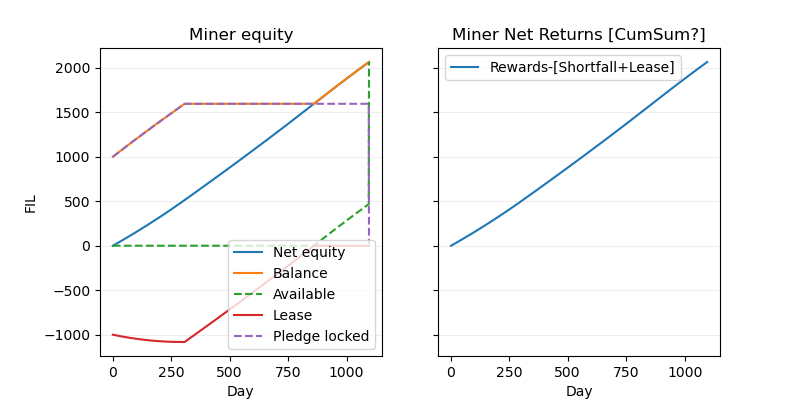

In [7]:
initial_pledge_projection_period_days = 20
supply_lock_target = 0.3
token_lease_fee = 0.2
max_shortfall_fraction = 0.5
max_repayment_term = 365*3
max_fee_reward_fraction = 0.25

eval_result = val_results['%0.03f,%0.03f,%0.03f,%0.03f,%0.03f' % 
                          (initial_pledge_projection_period_days, supply_lock_target, token_lease_fee, 
                           max_repayment_term, max_fee_reward_fraction)]
stats_df = pd.DataFrame(data=eval_result)
show_miner_accounting_charts(stats_df)

<IPython.core.display.Javascript object>


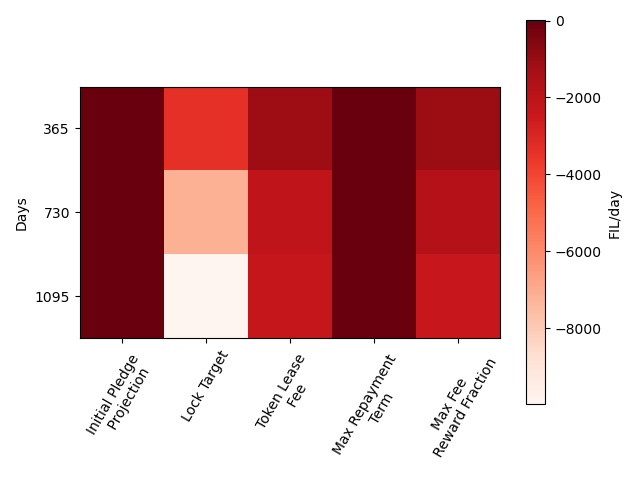

interactive(children=(IntSlider(value=20, description='ipppd', max=23, min=18), FloatSlider(value=0.3, descrip…

In [9]:
# Explore the Jacobian Results interactively
def get_closest_index(val, arr):
    idx = (np.abs(arr-val)).argmin()
    return idx   

def f(ipppd, lt, tlf, mrt, mfrf):
    mrt_val = mrt * 365  # convert Y to D
    # find closest indices
    ipppd_idx = get_closest_index(ipppd, initial_pledge_projection_period_days_vec)
    lt_idx = get_closest_index(lt, supply_lock_target_vec)
    tlf_idx = get_closest_index(tlf, token_lease_fee_vec)
    mrt_idx = get_closest_index(mrt_val, max_repayment_term_vec)
    mfrf_idx = get_closest_index(mfrf, max_fee_reward_fraction_vec)
    
    # generate dictionary key
    key = '%0.03f,%0.03f,%0.03f,%0.03f,%0.03f' % (
                initial_pledge_projection_period_days_vec[ipppd_idx],
                supply_lock_target_vec[lt_idx],
                token_lease_fee_vec[tlf_idx],
                max_repayment_term_vec[mrt_idx],
                max_fee_reward_fraction_vec[mfrf_idx]
            )
    # get jacobian
    jc = jacobian_results[key]
    
    return jc

fig, ax = plt.subplots()
def update(ipppd=20, lt=0.3, tlf=0.2, mrt=365*3, mfrf=0.25):
    new_data = f(ipppd, lt, tlf, mrt, mfrf)
    im.set_array(new_data)
    fig.canvas.draw_idle()
    
jc = f(20, 0.3, 0.2, 365*3, 0.25)
im = ax.imshow(jc, cmap='Reds')
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(['Initial Pledge \n Projection', 'Lock Target', 'Token Lease \n Fee', 
                    'Max Repayment \n Term', 'Max Fee \n Reward Fraction'], rotation=60)
fig.colorbar(im, label = 'FIL/day')
ax.set_yticks([0, 1, 2])
ax.set_yticklabels([365, 365*2, 365*3])
ax.set_ylabel('Days')

interact(update, ipppd = (18,23,1), lt = (0.3,0.5,0.1), tlf = (0.18,0.22,0.01), 
         mrt=(2.5,3.5,0.5), mfrf=(0.23,0.27,0.1))
plt.tight_layout()